In [1]:
from autograd import grad
import autograd.numpy as np
import matplotlib.pyplot as plt
from lista import LISTA, make_loss
from functions import *
from copy import deepcopy

In [6]:
layers = np.logspace(0, 2, 5, dtype=int)
n_samples = 1000
n_test = 100
k = 10
p = 3
K = np.eye(p)
fit_loss = 'logreg'
reg = 'l1'




fit_function, der_function = {
                              'l2': (l2_fit, l2_der),
                              'logreg': (logreg_fit, logreg_der)
                              }[fit_loss]
reg_function, prox = {
                      'l2': (l2_pen, l2_prox),
                      'l1': (l1_pen, l1_prox),
                      None: (no_pen, no_prox)
                      }[reg]
loss = make_loss(fit_function, reg_function)

z_true = np.random.randn(p, n_samples)
D = np.random.randn(k, p).dot(K)
D /= np.linalg.norm(D, axis=0, keepdims=True)

sigma = 0.1
eps = np.random.randn(k, n_samples)

z_test = np.random.randn(p, n_test)
eps_test = np.random.randn(k, n_test)
X = np.dot(D, z_true) + eps
X_test = np.dot(D, z_test) + eps_test
if fit_loss == 'logreg':
    X = 2 * (X > 0) - 1
    X_test = 2 * (X_test > 0) - 1
lbda_max = np.max(np.abs(np.dot(D.T, X)))
lbda = 0.02 * lbda_max
print('lambda = %.2e' % lbda)

lambda = 5.78e-02


In [7]:
ista = LISTA(D, lbda, 20000, fit_loss, reg)
z_hat = ista.transform(X)
f_min = loss(z_hat, X, D, lbda)
L = ista.L
print(np.linalg.norm(z_hat - prox(z_hat - np.dot(D.T / L, der_function(np.dot(D, z_hat), X)), lbda / L)))
print(f_min)

3.829766583549895e-15
4.899904031971913


In [9]:
loss_list = {'ista': [], 'lista': []}
for j, n_layers in enumerate(layers):
    print('%d layers' % n_layers)
    lista = LISTA(D, lbda, n_layers, fit_loss, reg, variables='both')
    loss_list['ista'].append(loss(lista.transform(X), X, D, lbda))
    # smart init
    if j > 0:
        lista.weights[:len(old_weights)] = old_weights
    lista.fit(X, l_rate=1e-1, max_iter=300, verbose=True)
    loss_list['lista'].append(loss(lista.transform(X), X, D, lbda))
    old_weights = deepcopy(lista.weights)

1 layers
it 0, loss = 5.475e+00, grad = 1.70e-01
it 100, loss = 5.286e+00, grad = 1.11e-01
it 200, loss = 5.194e+00, grad = 8.25e-02
3 layers
it 0, loss = 5.036e+00, grad = 1.55e-01
it 100, loss = 4.985e+00, grad = 6.06e-02
it 200, loss = 4.977e+00, grad = 4.00e-02
10 layers
it 0, loss = 4.925e+00, grad = 8.70e-02
it 100, loss = 4.918e+00, grad = 4.68e-02
it 200, loss = 4.915e+00, grad = 3.65e-02
31 layers
it 0, loss = 4.903e+00, grad = 3.72e-02
it 100, loss = 4.902e+00, grad = 2.05e-02
it 200, loss = 4.901e+00, grad = 1.72e-02
100 layers
it 0, loss = 4.900e+00, grad = 7.91e-03
it 100, loss = 4.900e+00, grad = 4.74e-03
it 200, loss = 4.900e+00, grad = 4.41e-03


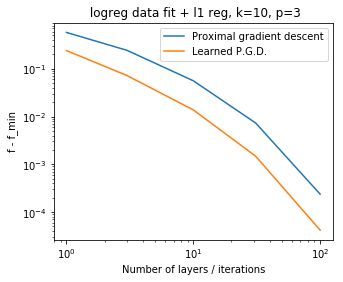

In [10]:
plt.figure(figsize=(5, 4))
title = ' %s data fit + %s reg, k=%d, p=%d' % (fit_loss, reg, n, p)
plt.title(title)
plt.plot(layers, np.array(loss_list['ista']) - f_min, label='Proximal gradient descent')
plt.plot(layers, np.array(loss_list['lista']) - f_min, label='Learned P.G.D.')
plt.xlabel('Number of layers / iterations')
plt.ylabel('f - f_min')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.savefig(title + '.pdf')
plt.show()